In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import seaborn as sns
from imblearn.over_sampling import SMOTE


In [2]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    pass

def get_root_dir():
    if os.path.exists('/content/drive/MyDrive/CS493Pro/'):
        return '/content/drive/MyDrive/CS493Pro/' #in colab
    else:
        return './'
    
os.chdir(get_root_dir())
print(os.listdir("./input_data"))
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Mounted at /content/drive
['clean_test_suicidalFP.csv', 'clean_test_leakFP.csv', 'clean_test_greedyFP.csv', 'clean_train.csv']


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import table

In [4]:
#define function
def label(df):
    df['LABEL'] = 0
    df.loc[df['CATEGORY'] == '1 0 0 0' , 'LABEL'] = 0 # one-hot vec
    df.loc[df['CATEGORY'] != '1 0 0 0' , 'LABEL'] = 1
    
def preprocess(df):
    n_most_common_words = 1000
    max_len = 130
    # instanciate the Class Tokenizer
    # Class Tokenizer is a text preprocessing library
    # This class allows to vectorize a text corpus, by turning each text into either a sequence of integers 
    # (each integer being the index of a token in a dictionary) 
    # or into a vector where the coefficient for each token could be binary
    # based on word count, based on tf-idf...
    tokenizer = Tokenizer(num_words = n_most_common_words, lower = False)
    #df['OPCODE'] retrieve the data under the label 'OPCODE',df is dataframe
    tokenizer.fit_on_texts(df['OPCODE'].values)
    sequences = tokenizer.texts_to_sequences(df['OPCODE'].values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    X = pad_sequences(sequences, maxlen=max_len)
    return X
    
def dftoXY(df):
    X_test = preprocess(df)
    
    label(df)
    print(pd.value_counts(df['LABEL']))
    y_test = to_categorical(df['LABEL'], num_classes = 2)
    return X_test, y_test


In [5]:
def XandY(posdf, negdf):
    dfset = pd.concat([posdf, negdf])
    dfset = dfset.sample(frac=1, random_state = 39, replace = False)
    
    dfset['LABEL'] = 0
    
    dfset.loc[dfset['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
    dfset.loc[dfset['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
    X, y = dftoXY(dfset)

    print('Shape of X: {}'.format(X.shape))
    y_labels = np.expand_dims(np.array(np.argmax(y, axis=1)), axis=1)
    print('Shape of y: {}'.format(y_labels.shape))

    return X, y_labels
    

In [6]:
dataset = 'clean_train.csv'
#read in data
data = pd.read_csv('./input_data/'+dataset, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
data.head()

,ADDRESS,OPCODE,CATEGORY
0,0x219f4ee903f78e78773e5d1e3520cfd507485bc6,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
1,0x560ed796aa8d23411b94b9d047ecdda39d4fcdeb,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
2,0xe726f97ff3c63dd71c1520c102adc39d1a2693ea,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
3,0x8ebac490495958b3804bb079e259340f0f53b69c,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
4,0x190700d69031db6b072a30577f9b3dbc53a320a1,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0


In [7]:
pd.value_counts(data['CATEGORY'])
# 1 0 0 0 is 0 other is 1

1 0 0 0    884273
0 0 0 1      5801
0 0 1 0      1461
0 1 0 0      1207
0 1 1 0       171
Name: CATEGORY, dtype: int64

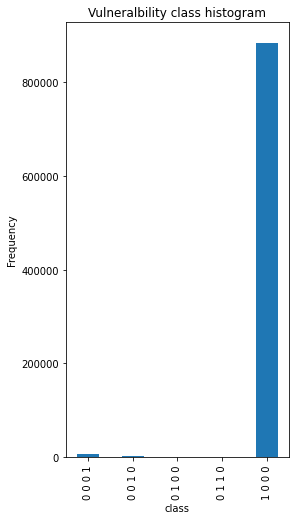

In [8]:
#Plot balance
fig = plt.figure()
count_classes = pd.value_counts(data['CATEGORY'], sort=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Vulneralbility class histogram")
plt.xlabel("class")
plt.ylabel("Frequency")
fig.set_size_inches(4, 8)
plt.show()

In [9]:
# Divide data into vulnerable & not-vulnerable
shuffled = data
#one-hot category
#not vulnerable data
n = shuffled[shuffled['CATEGORY'] == '1 0 0 0']
#suicidal contracts
s = shuffled[shuffled['CATEGORY'] == '0 1 0 0']
#prodigal contracts
p = shuffled[shuffled['CATEGORY'] == '0 0 1 0']
#greedy contracts
g = shuffled[shuffled['CATEGORY'] == '0 0 0 1']
#suicidal & greedy contracts
sg = shuffled[shuffled['CATEGORY'] == '0 1 1 0']



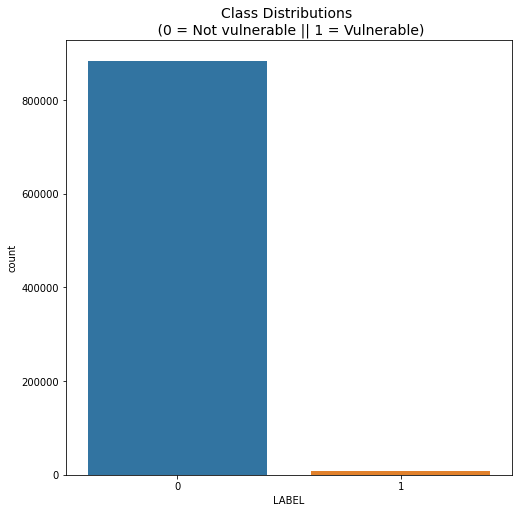

In [10]:
concated = pd.concat([n,s,p,g,sg], ignore_index = True)
#shuffle dataset
concated = concated.reindex(np.random.permutation(data.index))
concated['LABEL'] = 0

#one-hot encoding the lab
concated.loc[concated['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
fig = plt.figure()
colors = ["#0101DF","#DF0101"]
sns.countplot(x ='LABEL', data = concated)
plt.title('Class Distributions \n (0 = Not vulnerable || 1 = Vulnerable)', fontsize=14)
fig.set_size_inches(8, 8)

In [11]:
# Dividing data into train, validation, test
positives = pd.concat([s,p,g,sg])
#replace = True means sampling with replacement
positives_shuf = positives.sample(frac = 1, random_state = 39, replace = False)
print(len(positives_shuf))
#split positives into train, validation and tests
Proportion_train = 0.64
Proportion_val = 0.16
Proportion_test = 0.2

8640


In [12]:
#Split the positive dataset

num_pos_train = round(len(positives_shuf) * Proportion_train)
num_pos_val = round(len(positives_shuf) * Proportion_val)

pos_train = positives_shuf.iloc[0:num_pos_train]
pos_val = positives_shuf.iloc[num_pos_train:(num_pos_train + num_pos_val)]
pos_test = positives_shuf.iloc[(num_pos_train + num_pos_val):]

print("length of positive_train:",len(pos_train))
print("length of positive_validation:",len(pos_val))
print("length of positive_test:",len(pos_test))

length of positive_train: 5530
length of positive_validation: 1382
length of positive_test: 1728


In [13]:
#negative set shuffle
n_shuf = n.sample(frac = 1, random_state = 39, replace = False)
print(len(n_shuf))

num_neg_train = 3000 #30000 #11000
#num_neg_train)/Proportion_train gets the value of the sum of negative samples that are actually used
num_neg_val = round(((num_neg_train)/Proportion_train)*Proportion_val)
num_neg_test = round(((num_neg_train)/Proportion_train)*Proportion_test)

neg_train = n_shuf.iloc[0:num_neg_train]
neg_val = n_shuf.iloc[num_neg_train:(num_neg_train+num_neg_val)]
neg_test = n_shuf.iloc[(num_neg_train+num_neg_val):(num_neg_train+num_neg_val+num_neg_test)]
neg_notused = n_shuf.iloc[(num_neg_train+num_neg_val+num_neg_test):]
print("Number of negative samples not used: ", len(neg_notused))

print("Number of negative_train:",len(neg_train))
print("Number of negative_validation:",len(neg_val))
print("Number of negative_test:",len(neg_test))

884273
Number of negative samples not used:  879585
Number of negative_train: 3000
Number of negative_validation: 750
Number of negative_test: 938


In [14]:
# Prepare train set 
X_train, ytrain_labels = XandY(pos_train, neg_train)
# Prepare validation set 
X_val, yval_labels = XandY(pos_val, neg_val)
# Prepare test set 
X_test, ytest_labels = XandY(pos_test, neg_test)

Found 150 unique tokens.
1    5530
0    3000
Name: LABEL, dtype: int64
Shape of X: (8530, 130)
Shape of y: (8530, 1)
Found 150 unique tokens.
1    1382
0     750
Name: LABEL, dtype: int64
Shape of X: (2132, 130)
Shape of y: (2132, 1)
Found 150 unique tokens.
1    1728
0     938
Name: LABEL, dtype: int64
Shape of X: (2666, 130)
Shape of y: (2666, 1)


In [15]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", ytrain_labels.shape)
print("Number transactions X_val dataset: ", X_val.shape)
print("Number transactions y_val dataset: ", yval_labels.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", ytest_labels.shape)

print("Before OverSampling, counts of label '1' in Train: {}".format(sum(ytrain_labels==1)))
print("Before OverSampling, counts of label '0' in Train: {}".format(sum(ytrain_labels==0)))
print("Before OverSampling, counts of label '1' in Validation: {}".format(sum(yval_labels==1)))
print("Before OverSampling, counts of label '0' in Validation: {}".format(sum(yval_labels==0)))
print("Before OverSampling, counts of label '1' in Test: {}".format(sum(ytest_labels==1)))
print("Before OverSampling, counts of label '0' in Test: {} \n".format(sum(ytest_labels==0)))

Number transactions X_train dataset:  (8530, 130)
Number transactions y_train dataset:  (8530, 1)
Number transactions X_val dataset:  (2132, 130)
Number transactions y_val dataset:  (2132, 1)
Number transactions X_test dataset:  (2666, 130)
Number transactions y_test dataset:  (2666, 1)
Before OverSampling, counts of label '1' in Train: [5530]
Before OverSampling, counts of label '0' in Train: [3000]
Before OverSampling, counts of label '1' in Validation: [1382]
Before OverSampling, counts of label '0' in Validation: [750]
Before OverSampling, counts of label '1' in Test: [1728]
Before OverSampling, counts of label '0' in Test: [938] 



In [16]:
sm = SMOTE(random_state = 39)
X_train_res, y_train_res = sm.fit_resample(X_train, ytrain_labels.ravel())
X_val_res, y_val_res = sm.fit_resample(X_val, yval_labels.ravel())
X_test_res, y_test_res = sm.fit_resample(X_test, ytest_labels.ravel())

In [17]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_train_res.shape))
print('After OverSampling, the shape of val_X: {}'.format(X_val_res.shape))
print('After OverSampling, the shape of val_y: {}'.format(y_val_res.shape))
print('After OverSampling, the shape of test_X: {}'.format(X_test_res.shape))
print('After OverSampling, the shape of test_y: {} \n'.format(y_test_res.shape))

print("After OverSampling, counts of Train label '1' : {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of Train label '0' : {}".format(sum(y_train_res==0)))
print("After OverSampling, counts of Val label '1': {}".format(sum(y_val_res==1)))
print("After OverSampling, counts of Val label '0': {}".format(sum(y_val_res==0)))
print("After OverSampling, counts of Test label '1': {}".format(sum(y_test_res==1)))
print("After OverSampling, counts of Test label '0': {}".format(sum(y_test_res==0)))

After OverSampling, the shape of train_X: (11060, 130)
After OverSampling, the shape of train_y: (11060,)
After OverSampling, the shape of val_X: (2764, 130)
After OverSampling, the shape of val_y: (2764,)
After OverSampling, the shape of test_X: (3456, 130)
After OverSampling, the shape of test_y: (3456,) 

After OverSampling, counts of Train label '1' : 5530
After OverSampling, counts of Train label '0' : 5530
After OverSampling, counts of Val label '1': 1382
After OverSampling, counts of Val label '0': 1382
After OverSampling, counts of Test label '1': 1728
After OverSampling, counts of Test label '0': 1728


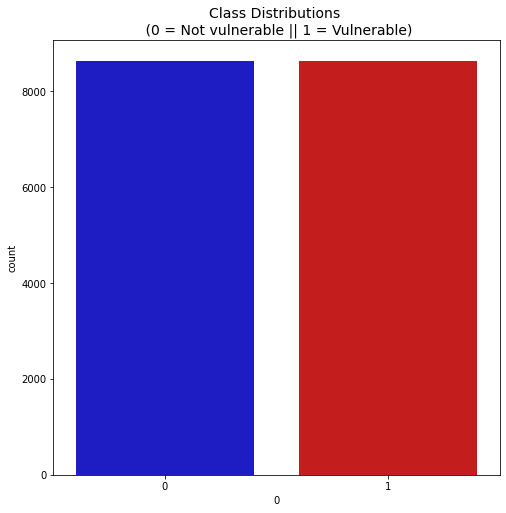

In [18]:
#Plot two datasets after resampling(Oversampling)
entire_dataset = np.concatenate((y_train_res, y_val_res, y_test_res))
fig = plt.figure()
sns.countplot(x = 0,data=pd.DataFrame(entire_dataset), palette=colors)
plt.title('Class Distributions \n (0 = Not vulnerable || 1 = Vulnerable)', fontsize=14)
fig.set_size_inches(8, 8)

In [19]:
# Init
epochs = 50 #100
emb_dim = 128 #150
batch_size = 256 #512  #256 

In [20]:
import keras
#Destroy the current TF graph and create a new one. Helps avoid old model/layer clutter
#clear model
keras.backend.clear_session()

In [21]:
#convert the dataset format for training
#to_categorical is the matrix type representation 
#that converts the category vector to binary (only 0 and 1)
ytrainres_cat = to_categorical(y_train_res, num_classes = 2)
yvalres_cat = to_categorical(y_val_res, num_classes = 2)
ytestres_cat = to_categorical(y_test_res, num_classes = 2)

print("X_train_resampling:",X_train_res.shape)
print("y_train_resampling_categorical:",ytrainres_cat.shape)
print("X_val_resampling:",X_val_res.shape)
print("y_val_resampling_categorical:",yvalres_cat.shape)
print("X_test_resampling:",X_test_res.shape)
print("y_test_resampling_categorical:",ytestres_cat.shape)

n_most_common_words = 1000 #150 
model = Sequential()

X_train_resampling: (11060, 130)
y_train_resampling_categorical: (11060, 2)
X_val_resampling: (2764, 130)
y_val_resampling_categorical: (2764, 2)
X_test_resampling: (3456, 130)
y_test_resampling_categorical: (3456, 2)


In [22]:
#Load Trained Model

In [23]:
model_name = 'improved_LSTM'
#model_name = 'V6_620k_batch9'

In [24]:
from keras.models import load_model
model = load_model('./saved_model/' + model_name + '.h5')


In [25]:
print(model.summary())
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
import time
start_time = time.time()
history = model.fit(X_train_res, ytrainres_cat, epochs = epochs, batch_size = batch_size, 
                    validation_split = 0.0, validation_data=(X_val_res, yvalres_cat),
                    callbacks=[EarlyStopping(monitor='loss',patience=7, min_delta=0.0001)])

end_time = time.time()
print("time for training:", end_time - start_time)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 130, 128)          128000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 130, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 148,674
Trainable params: 148,674
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
44/44 [==============================] - 36s 712ms/step - loss: 0.9804 - acc: 0.6850 - val_loss: 0

In [26]:
accr = model.evaluate(X_test_res, ytestres_cat)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

y_predict = model.predict(X_test_res, batch_size = 32, verbose = 1)
y_classes = np.argmax(y_predict,axis=1)
#y_test_real is the real value of y test set, which are labeled
y_test_real = y_test_res

from sklearn.metrics import average_precision_score
# print(y_test_real.shape)
# print(y_classes.shape)
# print(y_test_real)
# print(y_classes)
average_precision = average_precision_score(y_test_real, y_classes)
print('Average Precision Score is :{:0.4f}'.format(average_precision))

108/108 [==============================] - 6s 48ms/step - loss: 0.3570 - acc: 0.8834
Test set
  Loss: 0.3570
  Accuracy: 0.8834
108/108 [==============================] - 6s 50ms/step
Average Precision Score is :0.8452


In [27]:
#manually install funcsigs on Colab
!pip install funcsigs


In [28]:
from sklearn.metrics import precision_recall_curve
from funcsigs import signature

precision, recall, _ = precision_recall_curve(y_test_real, y_classes)
print(recall[1])
print('Recall Score: {:0.4f}\n'.format(recall[1]))

0.8622685185185185
Recall Score: 0.8623



In [29]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy:', accuracy_score(y_test_real, y_classes))
print('Recall:', recall_score(y_test_real, y_classes))
print('Precision:', precision_score(y_test_real, y_classes))
print('F1 score:', f1_score(y_test_real, y_classes))
print('\n clasification report:\n', classification_report(y_test_real, y_classes))
print('\n confusion matrix:\n',confusion_matrix(y_test_real, y_classes))

Accuracy: 0.8833912037037037
Recall: 0.8622685185185185
Precision: 0.9003021148036254
F1 score: 0.8808749630505469

 clasification report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89      1728
           1       0.90      0.86      0.88      1728

    accuracy                           0.88      3456
   macro avg       0.88      0.88      0.88      3456
weighted avg       0.88      0.88      0.88      3456


 confusion matrix:
 [[1563  165]
 [ 238 1490]]


In [30]:
import pickle
identifier = 'LSTM_improved'
#identifier = 'LSTM_improved_V6'
with open('./saved_model/' + identifier , 'wb') as file_pi:
    # 'wb' 
    pickle.dump(history.history, file_pi)

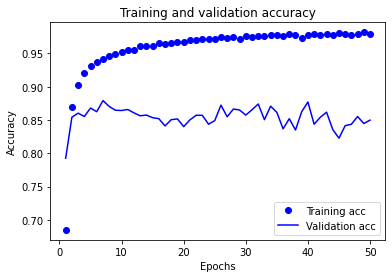

In [31]:
infile = open('./saved_model/' + identifier, 'rb')
history_0 = pickle.load(infile)
infile.close()
acc = history_0['acc']
val_acc = history_0['val_acc']
loss = history_0['loss']
val_loss = history_0['val_loss']


epochs = range(1, len(acc) + 1)

fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


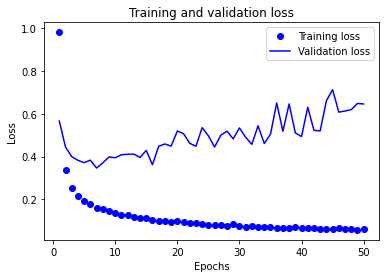

In [32]:
fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()